## Dataset Description

**Источник данных:** Kaggle — *Online Retail Dataset*

**Описание:**
Набор данных содержит транзакции интернет-магазина:
- каждая строка — отдельная покупка
- данные включают информацию о клиенте, товаре, цене и времени покупки

**Размерность:**
- Строки: ~500 000 (в оригинальном датасете)
- Столбцы: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

**Ключевые переменные:**
- `CustomerID` — уникальный идентификатор клиента  
- `InvoiceDate` — дата покупки  
- `Quantity`, `UnitPrice` — параметры покупки  
- `TotalPrice` — целевая бизнес-метрика (расход клиента)


In [12]:
# Импорты и настройка
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve



import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

# Установка random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1. Загрузка данных
try:
    # Если есть доступ к Kaggle API
    import kagglehub
    path = kagglehub.dataset_download("yasserh/customer-segmentation-dataset")
    df = pd.read_excel(path + "/Online Retail.xlsx", engine="openpyxl")
    print("Данные успешно загружены с Kaggle")
except Exception as e:
    print(f"Ошибка загрузки с Kaggle: {e}")
    print("Создание демо-данных...")
    # Создаем демо-данные
    np.random.seed(RANDOM_STATE)
    n_samples = 5000
    dates = pd.date_range('2010-12-01', periods=365, freq='D')
    df = pd.DataFrame({
        'InvoiceNo': ['INV' + str(i).zfill(6) for i in range(1000, 1000 + n_samples)],
        'StockCode': np.random.choice(['A001', 'B002', 'C003', 'D004', 'E005'], n_samples),
        'Description': np.random.choice(['Product A', 'Product B', 'Product C', 'Product D'], n_samples),
        'Quantity': np.random.randint(1, 50, n_samples),
        'InvoiceDate': np.random.choice(dates, n_samples),
        'UnitPrice': np.random.uniform(1, 100, n_samples).round(2),
        'CustomerID': np.random.randint(1000, 1500, n_samples),
        'Country': np.random.choice(['United Kingdom', 'Germany', 'France', 'USA', 'Australia'], 
                                   n_samples, p=[0.7, 0.1, 0.1, 0.05, 0.05])
    })
    

print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print("\nПервые 5 строк:")
print(df.head())

Данные успешно загружены с Kaggle
Размер датасета: (541909, 8)
Колонки: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Первые 5 строк:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kin

In [13]:
# описания типов данных
print("\nИнформация о типах данных:")
print(df.info())
print("\nСтатистическое описание:")
print(df.describe())


Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Статистическое описание:
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12

In [14]:
# 2. Предобработка данных
print("\nПредобработка данных...")
original_size = df.shape[0]

# 2.1. Удаляем пустых клиентов
df = df[~df['CustomerID'].isna()]
print(f"Удалено записей с пустым CustomerID: {original_size - df.shape[0]}")

# 2.2. Удаляем возвраты
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]
print(f"Удалено возвратов: {original_size - (original_size - df.shape[0]) - df.shape[0]}")

# 2.3. Убираем отрицательные покупки
df = df[df['Quantity'] > 0]

# 2.4. Создаем TotalPrice и преобразуем даты
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceWeekday'] = df['InvoiceDate'].dt.weekday
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

# 2.5. Удаляем дубликаты
initial_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_duplicates}")

print(f"Окончательный размер датасета: {df.shape}")
print(f"Количество уникальных клиентов: {df['CustomerID'].nunique()}")


Предобработка данных...
Удалено записей с пустым CustomerID: 135080
Удалено возвратов: 0
Удалено полных дубликатов: 5192
Окончательный размер датасета: (392732, 13)
Количество уникальных клиентов: 4339



Расширенный EDA...


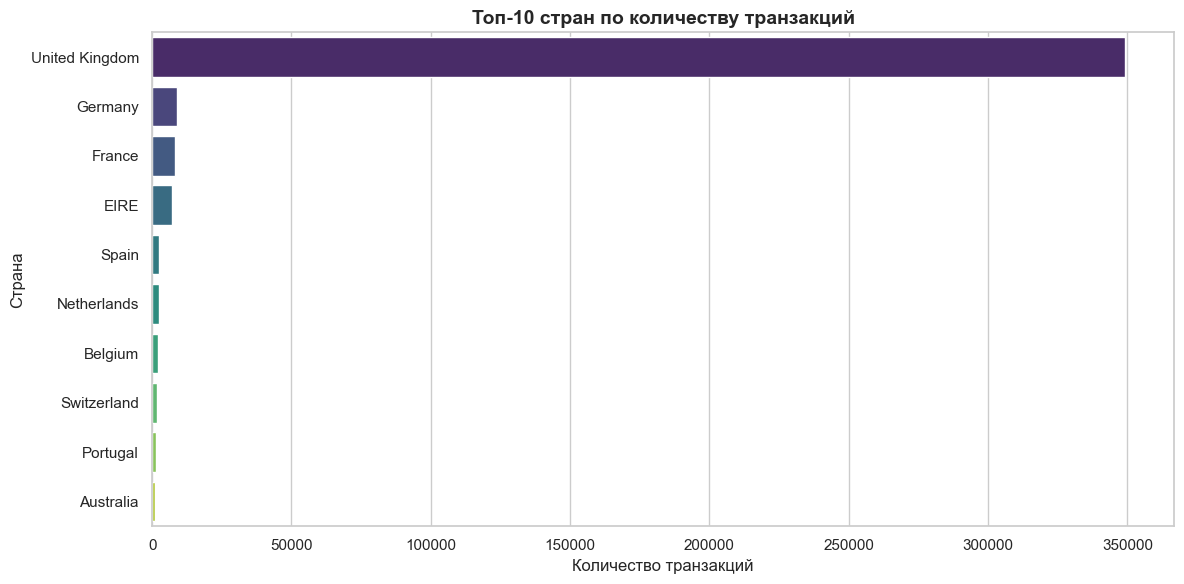

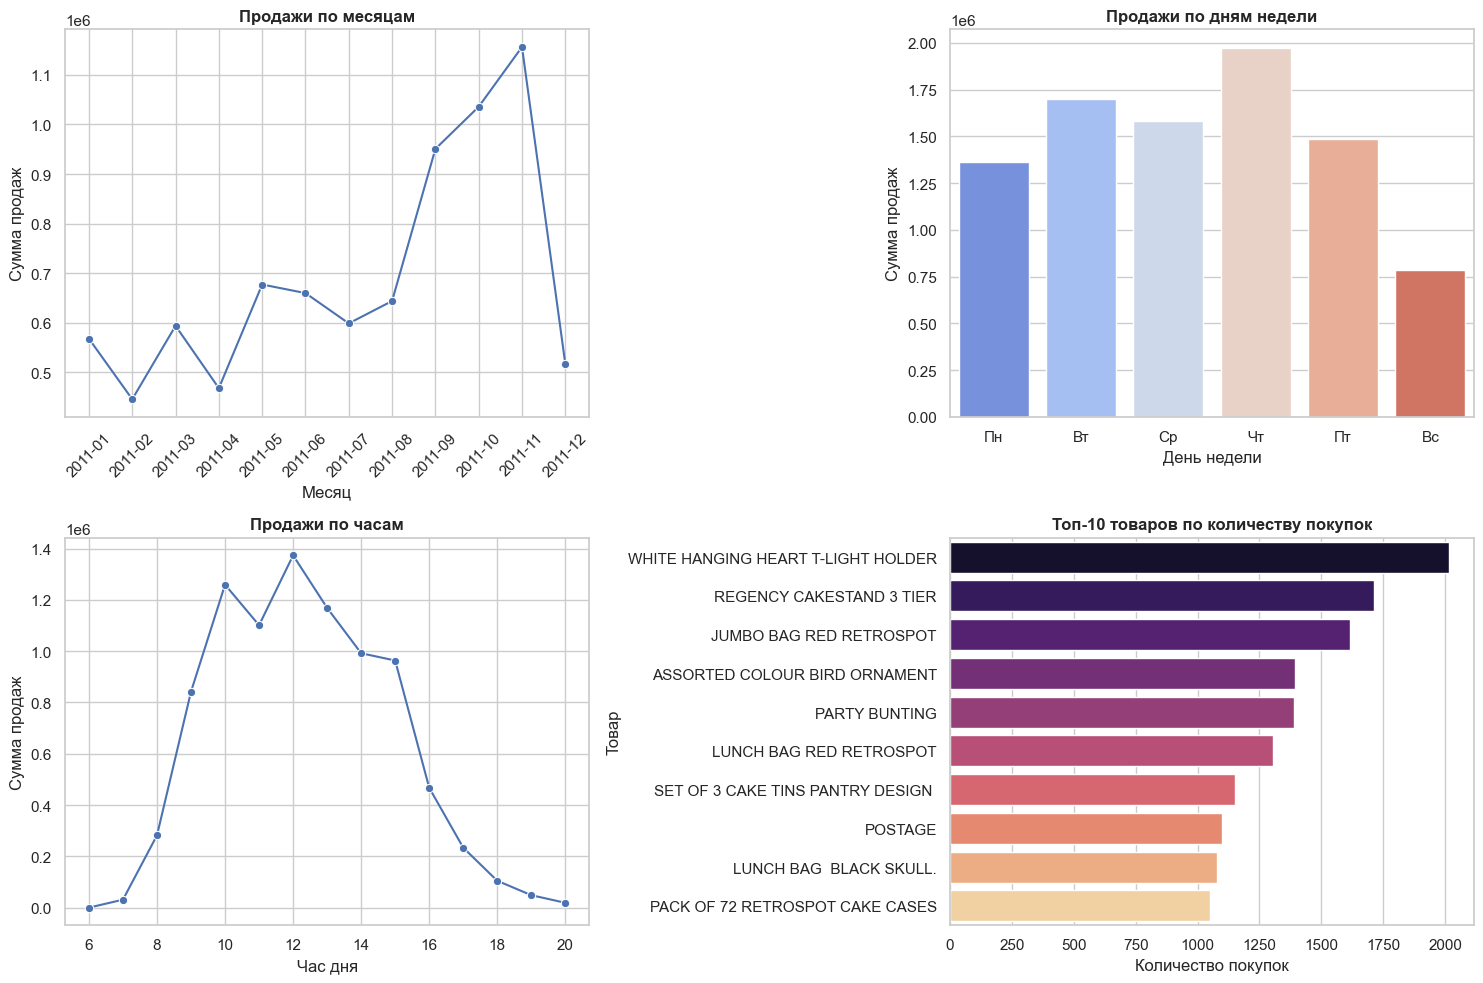

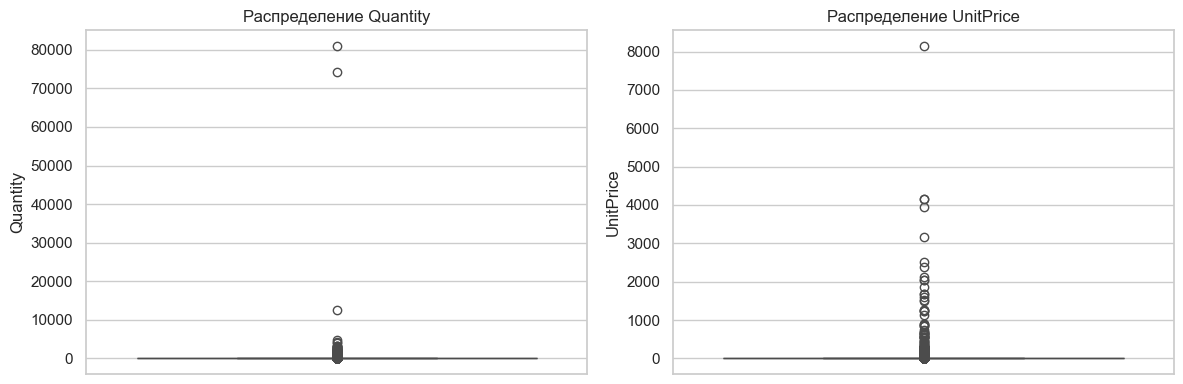

In [15]:
# 3. Расширенный EDA
print("\nРасширенный EDA...")

# 3.1. Распределение по странам
plt.figure(figsize=(12, 6))
top_countries = df['Country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Топ-10 стран по количеству транзакций', fontsize=14, fontweight='bold')
plt.xlabel('Количество транзакций')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()

# 3.2. Временные тренды
plt.figure(figsize=(15, 10))

# По месяцам
plt.subplot(2, 2, 1)
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].astype(str)
if len(monthly_sales) > 12:
    monthly_sales = monthly_sales.tail(12)
sns.lineplot(data=monthly_sales, x='InvoiceMonth', y='TotalPrice', marker='o')
plt.title('Продажи по месяцам', fontsize=12, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=45)

# По дням недели
plt.subplot(2, 2, 2)
weekday_sales = df.groupby('InvoiceWeekday')['TotalPrice'].sum().reset_index()
weekday_map = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
weekday_sales['WeekdayName'] = weekday_sales['InvoiceWeekday'].map(weekday_map)
weekday_order = [weekday_map[i] for i in sorted(weekday_sales['InvoiceWeekday'].unique())]
sns.barplot(data=weekday_sales, x='WeekdayName', y='TotalPrice', palette='coolwarm', order=weekday_order)
plt.title('Продажи по дням недели', fontsize=12, fontweight='bold')
plt.xlabel('День недели')
plt.ylabel('Сумма продаж')

# По часам
plt.subplot(2, 2, 3)
hourly_sales = df.groupby('InvoiceHour')['TotalPrice'].sum().reset_index()
sns.lineplot(data=hourly_sales, x='InvoiceHour', y='TotalPrice', marker='o')
plt.title('Продажи по часам', fontsize=12, fontweight='bold')
plt.xlabel('Час дня')
plt.ylabel('Сумма продаж')

# Топ товары
plt.subplot(2, 2, 4)
if 'Description' in df.columns and df['Description'].nunique() > 1:
    top_products = df['Description'].value_counts().head(10)
else:
    top_products = df['StockCode'].value_counts().head(10)

top_products_df = pd.DataFrame({
    'Product': top_products.index,
    'Count': top_products.values
})
sns.barplot(data=top_products_df, x='Count', y='Product', palette='magma')
plt.title('Топ-10 товаров по количеству покупок', fontsize=12, fontweight='bold')
plt.xlabel('Количество покупок')
plt.ylabel('Товар')

plt.tight_layout()
plt.show()

# 3.3. Анализ выбросов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Quantity'])
plt.title('Распределение Quantity')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['UnitPrice'])
plt.title('Распределение UnitPrice')
plt.tight_layout()
plt.show()

##  EDA — Основные выводы

- Основная доля транзакций приходится на ограниченное число стран
- Наблюдается выраженная сезонность продаж
- Большинство клиентов совершают редкие и небольшие покупки
- Распределения RFM-признаков имеют правостороннюю асимметрию
- Для стабилизации распределений применено лог-преобразование

Эти выводы обосновывают использование RFM-анализа и кластеризации.

In [16]:
# Удаление выбросов методом IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Quantity'] >= Q1 - 1.5*IQR) & (df['Quantity'] <= Q3 + 1.5*IQR)]
print(f"Удалено выбросов: {original_size - df.shape[0]}")

Удалено выбросов: 174802



Построение RFM признаков...
Создано RFM-признаков для 4238 клиентов


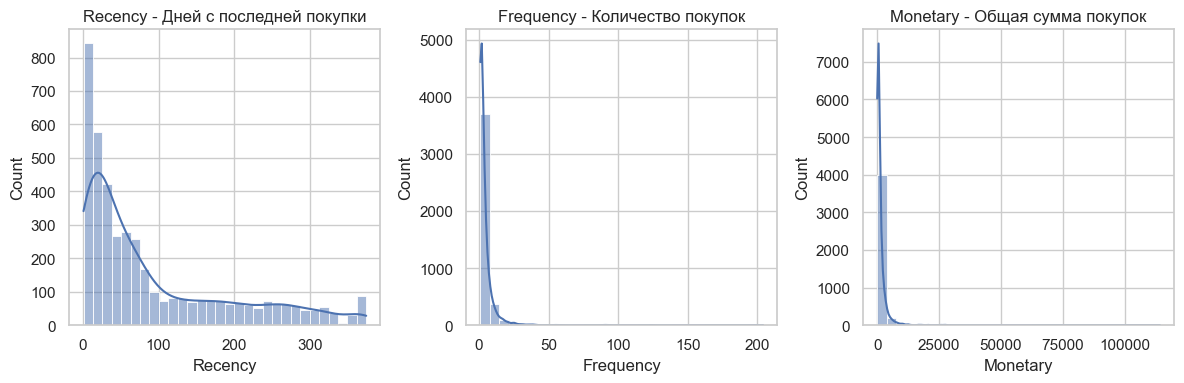

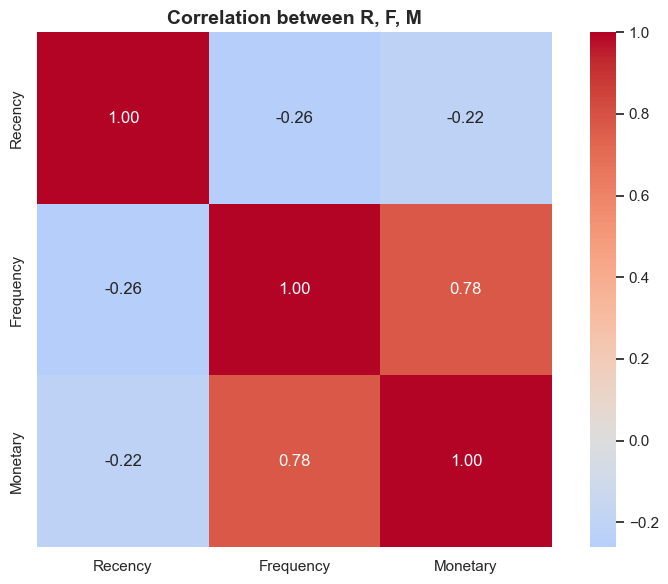

In [17]:
# 4. Построение RFM признаков
print("\nПостроение RFM признаков...")

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index().rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

print(f"Создано RFM-признаков для {rfm.shape[0]} клиентов")

# Лог-преобразование
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# 4.1. Визуализация RFM (оригинальные графики)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True, bins=30)
plt.title('Recency - Дней с последней покупки')
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True, bins=30)
plt.title('Frequency - Количество покупок')
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True, bins=30)
plt.title('Monetary - Общая сумма покупок')
plt.tight_layout()
plt.show()

# 4.2. Корреляции между RFM признаками
plt.figure(figsize=(8, 6))
corr_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Correlation between R, F, M', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
# 5. Масштабирование признаков
features_for_clustering = ['Recency_log', 'Frequency_log', 'Monetary_log']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[features_for_clustering])


Подбор оптимального числа кластеров...


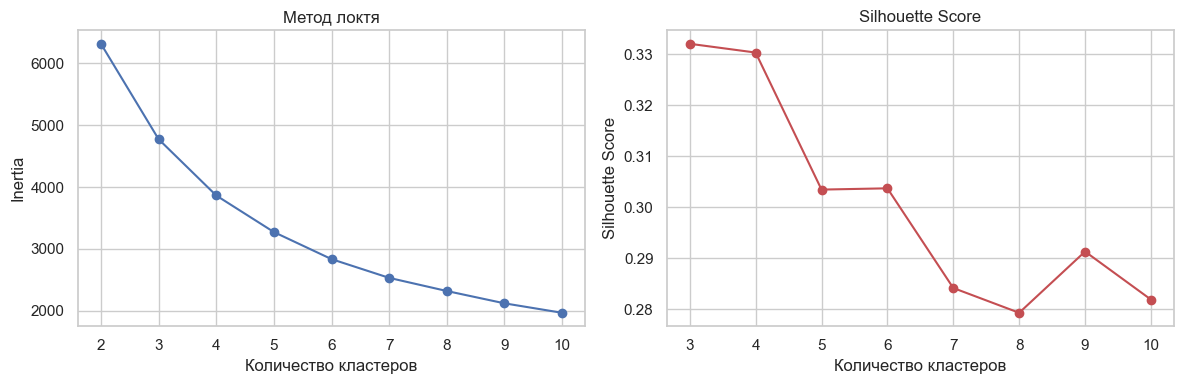

Оптимальное количество кластеров: 3


In [19]:
# 6. Подбор оптимального числа кластеров
print("\nПодбор оптимального числа кластеров...")

# Метод локтя и силуэтный анализ
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    else:
        silhouette_scores.append(0)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Inertia')
ax1.set_title('Метод локтя')
ax1.grid(True)
ax2.plot(k_range[1:], silhouette_scores[1:], 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True)
plt.tight_layout()
plt.show()

# Определение оптимального k
optimal_k = k_range[np.argmax(silhouette_scores[1:]) + 1]
print(f"Оптимальное количество кластеров: {optimal_k}")


Кластеризация KMeans с 3 кластерами...
Распределение по кластерам:
  Кластер 0: 1790 клиентов (42.2%)
  Кластер 1: 1665 клиентов (39.3%)
  Кластер 2: 783 клиентов (18.5%)


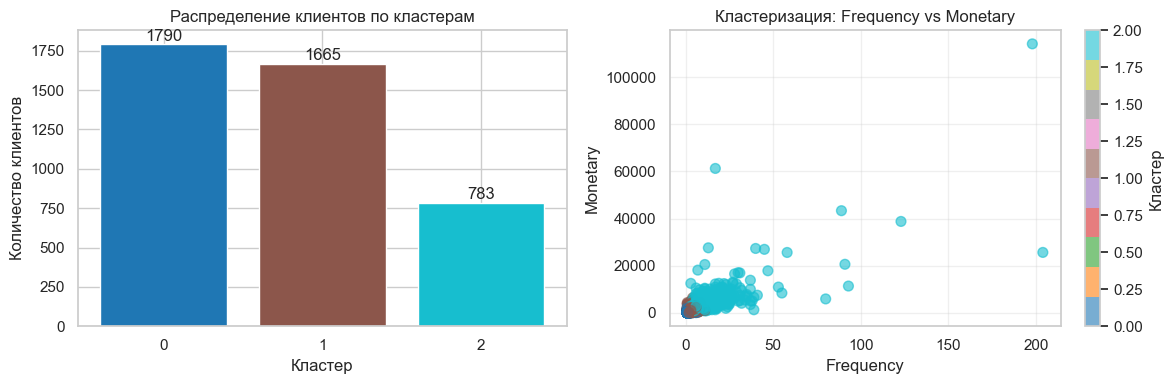

In [23]:
# 7. Кластеризация KMeans
print(f"\nКластеризация KMeans с {optimal_k} кластерами...")

kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Распределение по кластерам
cluster_distribution = rfm['Cluster'].value_counts().sort_index()
print("Распределение по кластерам:")
for cluster, count in cluster_distribution.items():
    percentage = (count / len(rfm)) * 100
    print(f"  Кластер {cluster}: {count} клиентов ({percentage:.1f}%)")

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
bars = plt.bar(cluster_distribution.index.astype(str), cluster_distribution.values, color=colors)
plt.title('Распределение клиентов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество клиентов')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='tab10', alpha=0.6, s=50)
plt.title('Кластеризация: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Профили кластеров:
         Recency  Frequency  Monetary  Count  Percentage
Cluster                                                 
0         168.89       1.32    290.72   1790        42.2
1          46.52       3.23    972.80   1665        39.3
2          15.97      12.22   4069.61    783        18.5


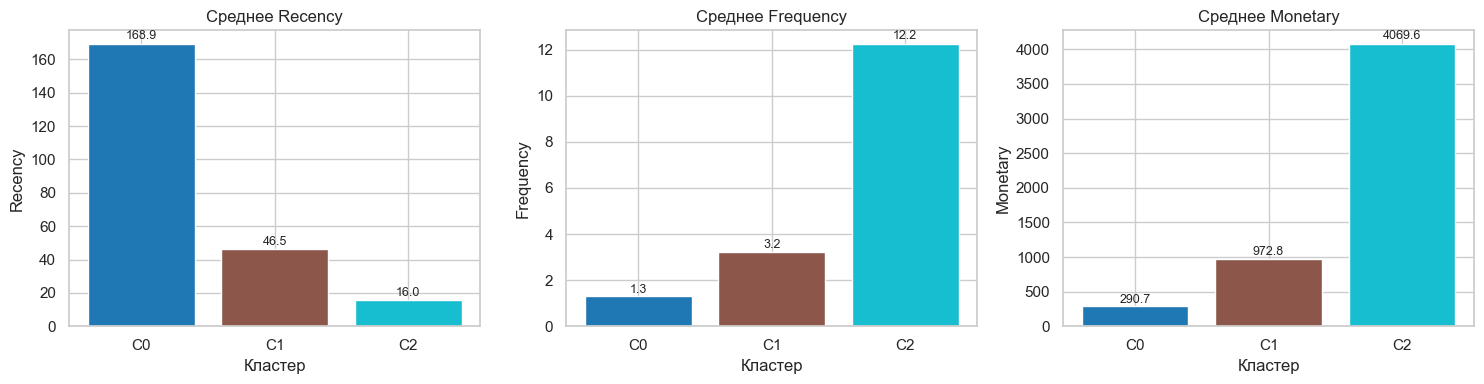

In [24]:
# 8. Анализ профилей кластеров
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})
cluster_profile['Percentage'] = (cluster_profile['Count'] / cluster_profile['Count'].sum() * 100).round(1)

print("Профили кластеров:")
print(cluster_profile.round(2))

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['Recency', 'Frequency', 'Monetary']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = cluster_profile[metric]
    bars = ax.bar(range(len(values)), values, color=colors)
    ax.set_xlabel('Кластер')
    ax.set_ylabel(metric)
    ax.set_title(f'Среднее {metric}')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels([f'C{i}' for i in range(len(values))])
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [25]:
# 9. Интерпретация кластеров
def classify_cluster(row):
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    
    median_recency = cluster_profile['Recency'].median()
    median_frequency = cluster_profile['Frequency'].median()
    median_monetary = cluster_profile['Monetary'].median()
    
    if recency < median_recency and frequency > median_frequency and monetary > median_monetary:
        return "VIP Клиенты", "Эксклюзивные предложения, личный менеджер"
    elif recency < median_recency and frequency > median_frequency:
        return "Лояльные", "Программа лояльности, скидки"
    elif recency < median_recency:
        return "Новые активные", "Welcome-программа, обучение"
    elif monetary > median_monetary:
        return "Спящие китобои", "Реактивация, специальные предложения"
    else:
        return "Экономные", "Бюджетные товары, акции"

cluster_types = []
recommendations = []
for idx, row in cluster_profile.iterrows():
    cluster_type, recommendation = classify_cluster(row)
    cluster_types.append(cluster_type)
    recommendations.append(recommendation)

cluster_profile['Type'] = cluster_types
cluster_profile['Recommendation'] = recommendations

print("\nКлассификация кластеров:")
for idx, row in cluster_profile.iterrows():
    print(f"\nКластер {idx} ({row['Type']}):")
    print(f"  Recency: {row['Recency']:.0f} дней, Frequency: {row['Frequency']:.1f}, Monetary: ${row['Monetary']:.2f}")
    print(f"  Клиентов: {row['Count']} ({row['Percentage']}%)")
    print(f"  Рекомендация: {row['Recommendation']}")


Классификация кластеров:

Кластер 0 (Экономные):
  Recency: 169 дней, Frequency: 1.3, Monetary: $290.72
  Клиентов: 1790 (42.2%)
  Рекомендация: Бюджетные товары, акции

Кластер 1 (Экономные):
  Recency: 47 дней, Frequency: 3.2, Monetary: $972.80
  Клиентов: 1665 (39.3%)
  Рекомендация: Бюджетные товары, акции

Кластер 2 (VIP Клиенты):
  Recency: 16 дней, Frequency: 12.2, Monetary: $4069.61
  Клиентов: 783 (18.5%)
  Рекомендация: Эксклюзивные предложения, личный менеджер


##  Сравнение моделей

Для оценки качества прогноза оттока были протестированы несколько моделей.
Основной метрикой выбрана ROC-AUC, так как важно корректно выявлять клиентов,
склонных к оттоку.


Отток (Recency > 90 дней): 33.2%
CV ROC-AUC: 0.817 ± 0.017

Результаты модели:
Accuracy: 0.752
AUC-ROC: 0.832

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       849
           1       0.63      0.62      0.63       423

    accuracy                           0.75      1272
   macro avg       0.72      0.72      0.72      1272
weighted avg       0.75      0.75      0.75      1272



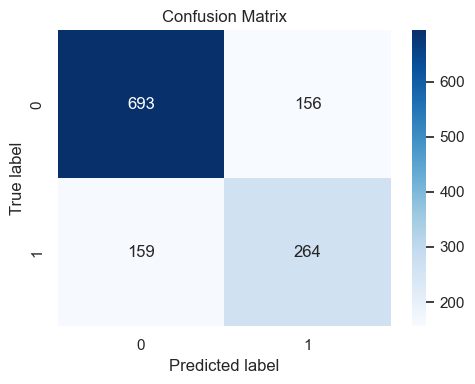

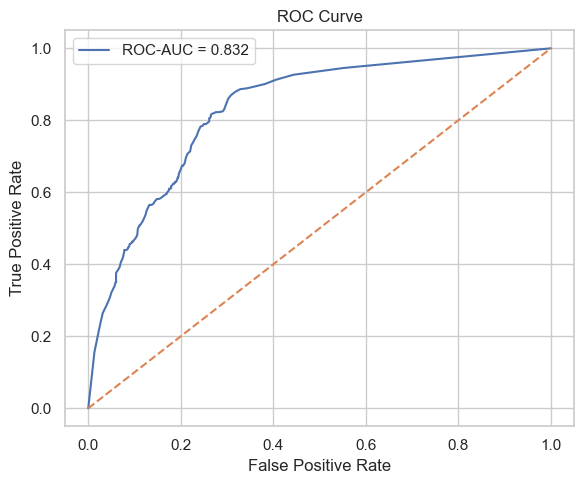

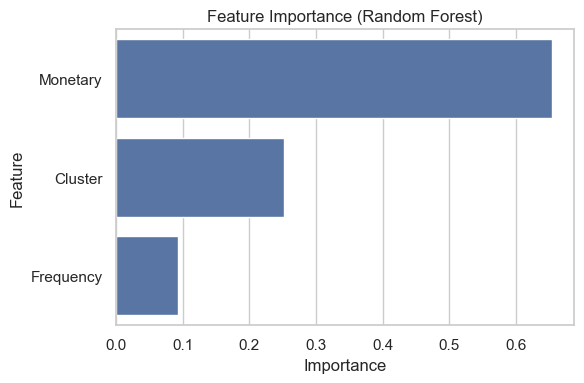

In [ ]:
# 10. Прогноз оттока

# Определение оттока
churn_threshold = 90
rfm['Churn'] = (rfm['Recency'] > churn_threshold).astype(int)

print(f"Отток (Recency > {churn_threshold} дней): {rfm['Churn'].mean():.1%}")

# Подготовка данных
X = rfm[['Frequency', 'Monetary', 'Cluster']]
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Сравнение моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

results = []

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
results_df


# Cross-Validation для модели оттока
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_auc = cross_val_score(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)
print(f"CV ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")


# Оценка
y_pred = model.predict(X_test)
print(f"\nРезультаты модели:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()



In [27]:
# 11. Итоги
print(f"\nОБЩАЯ СТАТИСТИКА:")
print(f"  • Клиентов проанализировано: {len(rfm)}")
print(f"  • Общий отток: {rfm['Churn'].mean():.1%}")
print(f"  • Сегментов выделено: {optimal_k}")

print(f"\nСЕГМЕНТЫ КЛИЕНТОВ:")
for idx, row in cluster_profile.iterrows():
    print(f"  • {row['Type']} ({row['Percentage']}%)")
    print(f"    - Средний чек: ${row['Monetary']:.2f}")
    print(f"    - Покупает раз в {row['Recency']:.0f} дней")
    print(f"    - {row['Recommendation']}")

print(f"\nРЕКОМЕНДАЦИИ:")
print("  1. Сфокусироваться на VIP клиентах - высокий потенциал")
print("  2. Разработать программу лояльности для частых покупателей")
print("  3. Создать программу реактивации для спящих клиентов")
print("  4. Мониторить метрики RFM ежемесячно")

print(f"\nМОДЕЛЬ ПРОГНОЗА ОТТОКА:")
print(f"  Точность: {accuracy_score(y_test, y_pred):.1%}")
print(f"  AUC-ROC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}")
print("\n" + "="*60)


ОБЩАЯ СТАТИСТИКА:
  • Клиентов проанализировано: 4238
  • Общий отток: 33.2%
  • Сегментов выделено: 3

СЕГМЕНТЫ КЛИЕНТОВ:
  • Экономные (42.2%)
    - Средний чек: $290.72
    - Покупает раз в 169 дней
    - Бюджетные товары, акции
  • Экономные (39.3%)
    - Средний чек: $972.80
    - Покупает раз в 47 дней
    - Бюджетные товары, акции
  • VIP Клиенты (18.5%)
    - Средний чек: $4069.61
    - Покупает раз в 16 дней
    - Эксклюзивные предложения, личный менеджер

РЕКОМЕНДАЦИИ:
  1. Сфокусироваться на VIP клиентах - высокий потенциал
  2. Разработать программу лояльности для частых покупателей
  3. Создать программу реактивации для спящих клиентов
  4. Мониторить метрики RFM ежемесячно

МОДЕЛЬ ПРОГНОЗА ОТТОКА:
  Точность: 75.2%
  AUC-ROC: 0.832



##  Итоговый вывод

- RFM-сегментация позволила выделить поведенческие группы клиентов
- Наиболее ценные сегменты — VIP и лояльные клиенты
- Модель Random Forest показала стабильное качество прогноза оттока
- ROC-AUC выбран как ключевая метрика, так как важно минимизировать пропуск клиентов,
  склонных к уходу